In [17]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import logistic_regression

In [21]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('seaborn')
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

from collections import Counter

## Load texts

Подгружаем тексты из сборников задач, которые нашли в интернете по данной тематике и достаем из них сами задачи

In [24]:
pattern = {'zadachi1.txt' : r'[0-9]+\.[0-9]+',
           'zadachi2.txt' : r'[0-9]+\.',
           'zadachi2.5.txt' : r'[0-9]+\.',
           'zadachi3.txt' : r'[0-9]+\.[0-9]+\.',
           'zadachi5.txt' : r'№[0-9]+',
          }
# Задаем паттерны начала строки, которая содержит в себе задачку
# Для каждого текста свои шаблоны

In [25]:
# Достаем из текстов сами условия заданий
tasks = []
for filename, pat in pattern.items() :
    texts = open('data_zadachi/{}'.format(filename), encoding = 'utf-8').read().split('\n') #cp1251
    
    for el in texts :
        if not re.search(pat, el) is None and len(el) > 50 :
            tasks.append(el)

In [26]:
len(tasks)

1927

In [27]:
data = pd.DataFrame(tasks, columns = ['texts'])

## Making predict

Делаем предсказания моделью обученной на текстах из википедиии и берем те, в которых моделька наиболее уверенна

In [9]:
model = logistic_regression.LogicticRegressionModel(pretrained=True) # Подгружаем предобученную модель
preparator = logistic_regression.LogicticRegressionPreparator() # Подгружаем модуль для обработки текстов

In [29]:
data['prepared'] = preparator.prepare_texts(data['texts']) # Делаем необходимую обработку текстов

100%|██████████| 1927/1927 [00:04<00:00, 451.81it/s]


In [30]:
data['prediction'] = model.predict(data['prepared']) # Предсказываем класс
data['score'] = model.predict_proba(data['prepared']).max(axis=1) # Уверенность модель в предсказанном классе

In [31]:
data.head()

,texts,prepared,prediction,score
0,\t1.1. Летом в спортивный лагерь ходили 50 дет...,1.1. лето спортивный лагерь ходить 50 ребёнок ...,спорт,0.985258
1,\t1.2. На концерте в летнем лагере ребята игра...,1.2. концерт летний лагер ребята играть гитара...,музыка,0.957977
2,\t1.3. В конце учебного года во 2 классе фотог...,1.3. конец учебный год 2 класс фотограф сделат...,литература,0.900861
3,\t1.4. Во время летних соревнований по плавани...,1.4. время летний соревнование плавание ребята...,спорт,0.986303
4,\t1.5. В спортивную школу во время летних кани...,1.5. спортивный школа время летний каникулы ку...,спорт,0.990449


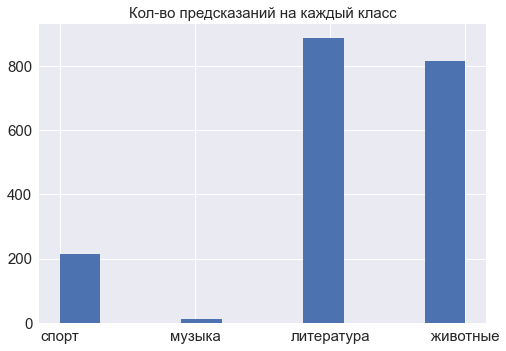

In [32]:
plt.hist(data['prediction'])
plt.title('Кол-во предсказаний на каждый класс')
plt.show()

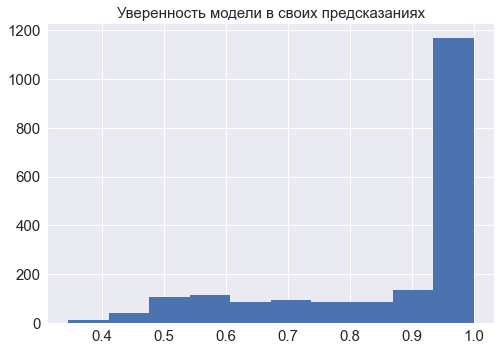

In [33]:
plt.hist(data['score'])
plt.title('Уверенность модели в своих предсказаниях')
plt.show()

## Translate dataset to English

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions
import pandas as pd
import json
import pickle
import time
import re
import sys
from tqdm import tqdm

In [2]:
chrome_options = ChromeOptions()
# chrome_options.add_argument("--headless")

driver = webdriver.Chrome("/usr/lib/chromium-browser/chromedriver", options=chrome_options)
# driver = webdriver.Remote(
#     command_executor='http://194.163.165.205:4444/wd/hub',
#     options=chrome_options,
# )


In [29]:
def translate_text(text, direction='ru-en'):
    time.sleep(0.2)
    driver.get(f"https://www.m-translate.ru/translator/text#text=test&direction=ru-en")
    
    from_lang = driver.find_element_by_id("from_span").text.lower()
    if from_lang != direction[:direction.find('-')]:
        driver.find_element_by_id("Small_btns").click()
        
    driver.find_element_by_id("text").clear()
    driver.find_element_by_id("text").send_keys(text)
    driver.find_element_by_id("go_btn").click()
    while driver.find_element_by_id("text_out").get_attribute("value") == "":
        time.sleep(0.2)
    return driver.find_element_by_id("text_out").get_attribute("value")


In [30]:
translate_text('Новый текст', 'ru-en')

'New text'

In [31]:
translate_text("Hi, I'm from Moscow", 'en-ru')

'Привет я из москвы'

In [39]:
driver.close()

In [17]:
data = pd.read_csv('../full_marked_dataset.csv')
data.head()

,Unnamed: 0,text,ans
0,0,\t1.1. Летом в спортивный лагерь ходили 50 дет...,спорт
1,1,\t1.2. На концерте в летнем лагере ребята игра...,музыка
2,2,\t1.3. В конце учебного года во 2 классе фотог...,неизвестно
3,3,\t1.4. Во время летних соревнований по плавани...,спорт
4,4,\t1.5. В спортивную школу во время летних кани...,спорт


In [32]:
def make_good(text):
    text = text.replace('\n', '').replace('\t','')
    ind = 0
    while ind < len(text) and not (text[ind] > 'А' and text[ind] < 'Я'):
        ind += 1
        
    if ind == len(text):
        text = text[text.find(' ') + 1:]
    else:
        text = text[ind:]
    return text
    
splitter = ' [SPLIT] '
texts = [make_good(el) for el in data['text'].values]


translated_texts = []

for i in tqdm(range(0, len(data), 3)):
    now = texts[i:i + 3]
    translated = translate_text(splitter.join(now)).split(splitter[1:-1])
    translated_texts += translated
    
data['translated'] = translated_texts    

100%|█████████████████████████████████████████| 643/643 [18:37<00:00,  1.74s/it]


In [35]:
data.to_csv('full_marked_translated.csv')

In [36]:
data.head()

,Unnamed: 0,text,ans,translated
0,0,\t1.1. Летом в спортивный лагерь ходили 50 дет...,спорт,"In the summer, 50 children went to the sports ..."
1,1,\t1.2. На концерте в летнем лагере ребята игра...,музыка,The guys played guitars at the summer camp co...
2,2,\t1.3. В конце учебного года во 2 классе фотог...,неизвестно,"At the end of the school year in 2nd grade, a..."
3,3,\t1.4. Во время летних соревнований по плавани...,спорт,"During the summer swimming competition, the gu..."
4,4,\t1.5. В спортивную школу во время летних кани...,спорт,We bought 10 tennis and 12 volleyball balls f...
